# Assignment 02

## 1. Significant earthquakes since 2150 B.C.

The Significant Earthquake Database contains information on destructive earthquakes from 2150 B.C. to the present. On the top left corner, select all columns and download the entire significant earthquake data file in .tsv format by clicking the Download TSV File button. Click the variable name for more information. Read the file (e.g., earthquakes-2025-10-29_15-11-32_+0800.tsv) as an object and name it Sig_Eqs.

In [619]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime
import matplotlib.dates as mdates
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

### 1.1

[5 points] Compute the total number of deaths caused by earthquakes since 2150 B.C. in each country, and then print the top ten countries along with the total number of deaths.

依据题目要求，对下载的数据表格进行处理，主要需要从 Location Name 中提取地震发生所在的国家，官网的说明中，其结构为 Country State City，但在实际的数据中存在多种格式，因此这里通过分隔符 `:` 和 `;` 对所在国家进行初步提取。对初步提取的结果，通过 AI 和人工修正的方式决定其准确所在国家。另外，由于一场地震可能涉及多个国家，但并没有额外的数据可以用于衡量每个国家的损失大小，因此这里进行平均分配。

In [620]:
# [x.split(':')[0] for x in Sig_Eqs["Location Name"]]
# [x[0] for x in Sig_Eqs["Location Name"].str.split(':')]
# Barbados, saint vincent, dominica, antigua: four country
# Armenia-azerbaijan-iran: three country
# Antigua island &  st. christopher: two country
# Boso, japan: Japan city
# Boston and salem, massachusetts: America city
# California, mexico: America city and country
# E. awa, tokushima prefecture: Japan
# E. luzon island, philippines: philippines
# E. sporades islands, aegean islands: Greece
# East mediterranean sea: no country
# East pacific ridge: no country
# Enshunada: Mexico city

Sig_Eqs = pd.read_table("./data/earthquakes-2025-10-29_20-30-02_+0800.tsv") # 读取数据库
Sig_Eqs = Sig_Eqs.iloc[1:] # 跳过第一行
Sig_Eqs.reset_index(inplace=True) # 重置索引

def get_base_from_location(location: str) -> list:
    """
    # Parameters:
        location, str   : Location Name in earthquakes dataset
    # Returns:
        List of countrys
    # Note
    依照数据库的规则（country: region）进行基本的区分，将给定位置的国家提取出来。
    实际会有一些例外情况，例如：
    - Barbados, saint vincent, dominica, antigua （四个国家，但并未通过 `;` 分隔）
    - Armenia-azerbaijan-iran （三个国家，但通过连字符连接，而非分号分隔）
    - Boso, japan: Japan city （国家名后置，且不使用冒号分隔国家和地区）
    - Boston and salem, massachusetts （没有给出所在国家，仅给了州或县，在美国、加拿大、墨西哥、日本等地常出现）
    - East mediterranean sea （没有所在国家）
    """
    country_list = []
    location = location.strip() # 去除多余的空格
    if ";" in location: # 使用 ; 分隔文本，返回列表
        location_list = location.split(';')
    else:
        location_list = [location]
    for location_tmp in location_list: # 对列表进行循环，去除 : 后的内容，并去除多余的空格
        if len(location_tmp) > 0: # 排除为空的情况
            if ":" in location_tmp:
                country_list += [location_tmp.split(':')[0].strip()]
            else:
                country_list += [location_tmp.strip()]
    return country_list

# 获取每个位置的名称，并依据最基本的规则获取所有可能的国家（存在很大误差）
df = pd.DataFrame()
for i in Sig_Eqs.index:
    location = Sig_Eqs.loc[i, "Location Name"]
    countrys = get_base_from_location(location)
    for country in countrys:
        if not country in df.index:
            df.loc[country, "Location Name"] = location
df.to_csv("./data/PS2_country.csv")

# 将 PS2_country.csv 输入 AI，然后对 AI 回答的结果进行人工校对，得到最终的对照表 earthquakes-country.xlsx
# 根据对照表获取一份字典 country_info_dict，对应 get_base_from_location 输出的位置和实际所在的国家
country_info = pd.read_excel("./data/earthquakes-country.xlsx")
country_info = country_info.set_index("Name")
country_info_dict = {x.upper(): country_info.loc[x, "Country"].split(", ") for x in country_info.index}

def get_country_from_location(location: str) -> list:
    """
    # Parameters:
        location, str   : Location Name in earthquakes dataset
    # Returns:
        List of countrys
    # Note
    依据修正后的对照表对国家名称进行匹配
    """
    country_list = []
    location = location.strip()
    if ";" in location:
        location_list = location.split(';')
    else:
        location_list = [location]
    for location_tmp in location_list:
        location_tmp = location_tmp.strip()
        if len(location_tmp) > 0:
            try:
                if ":" in location_tmp:
                    country_list += country_info_dict[location_tmp.split(':')[0].strip()]
                else:
                    country_list += country_info_dict[location_tmp.strip()]
            except:
                print(location, '|', location_tmp)
                raise IndexError
    return country_list

Sig_Eqs_list = [] # 用于保存一场地震对应多个国家的情景，最终会被合并到原列表中
num_list = ["Deaths", "Missing", "Injuries", "Damage ($Mil)", "Houses Destroyed", "Houses Damaged", "Total Deaths", "Total Missing", "Total Injuries", "Total Damage ($Mil)", "Total Houses Destroyed", "Total Houses Damaged"] # 将同一场地震分配到不同国家，需要计算的列
index_other = len(Sig_Eqs) # 用于确认被分出来的行具体所在行
Sig_Eqs_old = Sig_Eqs.copy() # 备份用于其他分析
for index, row in Sig_Eqs.iterrows():
    country_list = get_country_from_location(row["Location Name"]) # 获取地震对应国家
    n_country = len(country_list)
    Sig_Eqs.loc[index, "Country"] = country_list[0] # 修改原始记录为第一个国家
    Sig_Eqs.loc[index, num_list] //= n_country # 将地震损失/伤亡平均分配到每个国家
    if len(country_list) > 1: # 如果国家数大于 1，则增加新的条目
        for country_tmp in country_list[1:]:
            df_tmp = Sig_Eqs.loc[index].copy()
            df_tmp["Country"] = country_tmp # 修改新增条目的所在国家
            df_tmp.name = index_other # 更新新增条目的所在行
            Sig_Eqs_list.append(df_tmp) # 将新增条目加入列表
            index_other += 1 # 递增所在行
Sig_Eqs = pd.concat([Sig_Eqs, pd.concat(Sig_Eqs_list, axis=1).T]) # 合并新增条目到原表格

# # Sig_Eqs["Country"] = Sig_Eqs["Location Name"].str.extract(r'^([^:]*):')[0].str.capitalize().dropna(how="all")
# Sig_Eqs[["Location Name", "Country"]].groupby("Country").apply(lambda x: x.iloc[0]).to_csv("PS2_country.csv", sep="\t")
# result = []
# for x in Sig_Eqs["Location Name"].apply(get_country_from_location):
#     for y in x:
#         if not y in result:
#             result.append(y)
# df3 = pd.DataFrame()
# df3["Country"] = result
# df3["Country"].str.upper().drop_duplicates()
# tmp = df3["Country"].str.upper()
# for x in tmp:
#     if (tmp==x).sum() > 1:
#         print(x)
# Sig_Eqs["Location Name"].apply(get_country_from_location)

In [621]:
# 按国家对死亡人数进行分组求和，并按照死亡人数排序得到前 10 个死亡人数最多的国家
print(Sig_Eqs.loc[:, ["Total Deaths", "Country"]].groupby("Country").sum().sort_values("Total Deaths", ascending=False).head(10))

           Total Deaths
Country                
China         2159641.0
Turkey         993261.0
Iran           828692.0
Syria          434409.0
Italy          423280.0
Haiti          323782.0
Japan          319294.0
Azerbaijan     318501.0
Indonesia      282898.0
Pakistan       154277.0


### 1.2

[10 points] Compute the total number of earthquakes with magnitude larger than 6.0 (use column Mag as the magnitude) worldwide each year, and then plot the time series. Do you observe any trend? Explain why or why not?

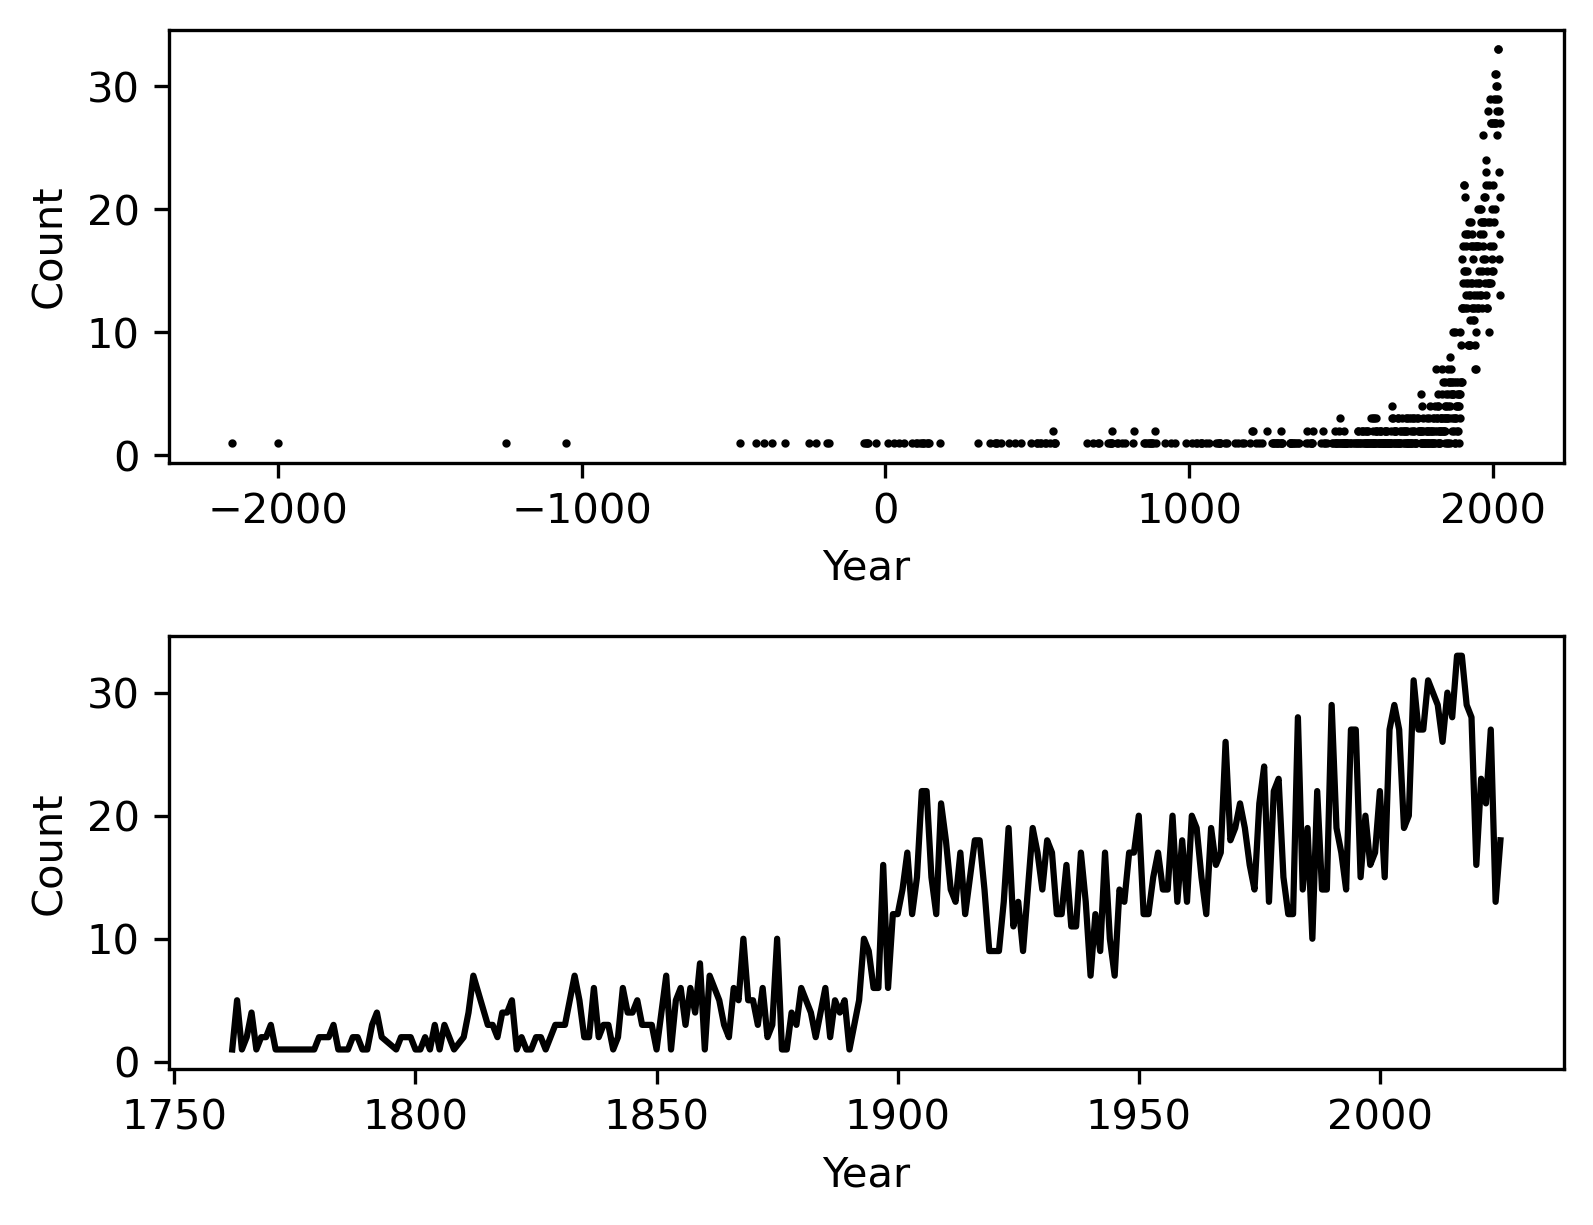

In [622]:
df = Sig_Eqs_old.loc[Sig_Eqs_old["Mag"]>6, ["Year", "Mag"]].groupby(["Year"]).count() # 统计震级 6 级以上的地震数
x, y = np.array(df.index), np.array(df.loc[:, "Mag"])
fig = plt.figure(figsize=[6, 4.5], dpi=300)
spec = fig.add_gridspec(ncols=1, nrows=2, hspace=0.4)
# 绘制公元前 2150 年至今的趋势图
ax = fig.add_subplot(spec[0])
ax.plot(x, y, "ko", ms=1)
ax.set(xlabel="Year", ylabel="Count")
# 绘制近 250 年的趋势图
ax = fig.add_subplot(spec[1])
ax.plot(x[-250:], y[-250:], "k-", ms=1)
ax.set(xlabel="Year", ylabel="Count")
fig.savefig("./images/PS2_1_figure1.jpg", bbox_inches="tight")

从整体的趋势看，在公元前的地震记录非常稀疏，直到近几百年地震记录逐渐增加，这应当是由技术手段的改进导致对地震的探测能力增强，以往不能探测到的地震被探测到了，并不能代表地震数目的显著增加。绘制近 250 年的数据显示，6 级以上地震数目在 1900 年左右有显著的增加（官网在 Location Name 字段的说明下也说了 1900 年之前缺少仪器定位），然后长期稳定在每年 15 次左右。

### 1.3

[10 points] Write a function CountEq_LargestEq that returns both (1) the total number of earthquakes since 2150 B.C. in a given country AND (2) the date of the largest earthquake ever happened in this country. Apply CountEq_LargestEq to every country in the file, report your results in a descending order.

In [630]:
from typing import Union
import datetime as dt

# def CountEq_LargestEq(df: pd.DataFrame, country: str = None) -> Union[int, dt.datetime]:
#     df_tmp = df.loc[df["Country"]==country].sort_values("Mag", ascending=False).reset_index(inplace=True)
#     num = len(df_tmp)
#     date = dt.date(int(df_tmp.loc[0, "Year"]), int(df_tmp.loc[0, "Mo"]), int(df_tmp.loc[0, "Dy"]))
#     return num, date

def CountEq(df: pd.DataFrame) -> int:
    """
    目的是为了计算地震的数目，当然这里写的并不严谨，因为之前按照国家对同一场地震进行了分配。不过考虑到最终计算时会对国家进行循环，因此在这里并无影响。
    """
    return len(df)

def LargestEq(df: pd.DataFrame) -> str:
    """
    计算最大地震所在的日期，并返回日期字符串。如果没有具体月份则设为当年 1 月，如果没有具体日则设为当月 1 日。
    """
    if not all(df["Mag"].isna()): # 如果不是所有的震级都是 NaN，则获取对应的年月日，并返回字符串
        largest_row = df.loc[df["Mag"].idxmax(skipna=True)]
        year = int(largest_row["Year"])
        month = int(largest_row["Mo"]) if not np.isnan(largest_row["Mo"]) else 1
        day = int(largest_row["Dy"]) if not np.isnan(largest_row["Dy"]) else 1
        largest_date = f"{year:+05d}-{month:02d}-{day:02d}"
    else: # 否则返回 None
        largest_date = None
    return largest_date

def CountEq_LargestEq(df):
    return CountEq(df), LargestEq(df)

# 创建一个新的表格保存分析结果
Eq_info = pd.DataFrame()
for country in Sig_Eqs["Country"].unique(): # 对于所有国家循环，计算地震总数和最大地震日期
    Eq_info.loc[country, ["CountEq", "LargestEqDate"]] = CountEq_LargestEq(Sig_Eqs.loc[Sig_Eqs["Country"]==country])
print(Eq_info.sort_values(by="CountEq", ascending=False)) # 按照地震总数降序排列

             CountEq LargestEqDate
China            735   +1950-08-15
Japan            423   +2011-03-11
Indonesia        418   +2004-12-26
Iran             398   +0856-12-22
Turkey           375   +1939-12-26
...              ...           ...
Gabon              1   +1974-09-23
Burundi            1   +2004-02-24
Sierra leone       1   +1795-05-20
Guinea             1   +1983-12-22
Zimbabwe           1   +2018-12-22

[157 rows x 2 columns]


## 2. Wind speed in Shenzhen from 2010 to 2020

In this problem set, we will examine how wind speed changes in Shenzhen during the past 10 years, we will take a look at the hourly weather data measured at the BaoAn International Airport. The data set is from NOAA Integrated Surface Dataset. Download the file 2281305.zip, where the number 2281305 is the site ID. Extract the zip file, you should see a file named 2281305.csv. Save the .csv file to your working directory.

Read page 8-9 (POS 61-70) of the comprehensive user guide for the detailed format of the wind data. Explain how you filter the data in your report.

在 User Guide 中描述了风速相关数据的说明，其中所有数字为 9 的则表示数据存在问题。依据网络搜索得到的结果，在数据中风相关信息保存在列 WND 中，分别为"风向角度,风向质控,观测类型,风速,风速质控"，其中风速需要除以 10 转化为米每秒，并保留质控标记为 0、1、2、4、5、6、9 的结果（排除被怀疑或者错误的结果），并排除观测类型为 9 且风速不为 0 的结果（观测类型为 9 且风速不为 0 表示缺失，观测类型为 9 且风速为 0 表示静风状态）。

[10 points] Plot monthly averaged wind speed as a function of the observation time. Is there a trend in monthly averaged wind speed from 2010 to 2020?

/var/folders/tb/s_lb3f3x1_qfqfyh_7r6hzs00000gn/T/ipykernel_45492/943873780.py:3: DtypeWarning: Columns (4,8,9,12,15,21,22,24,26,31,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/2281305.csv", parse_dates=["DATE"], na_values=999).loc[:, ["STATION", "DATE", "WND"]]
/var/folders/tb/s_lb3f3x1_qfqfyh_7r6hzs00000gn/T/ipykernel_45492/943873780.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_wind_speed_monthly = df_wind_speed_qc.resample("M").mean()


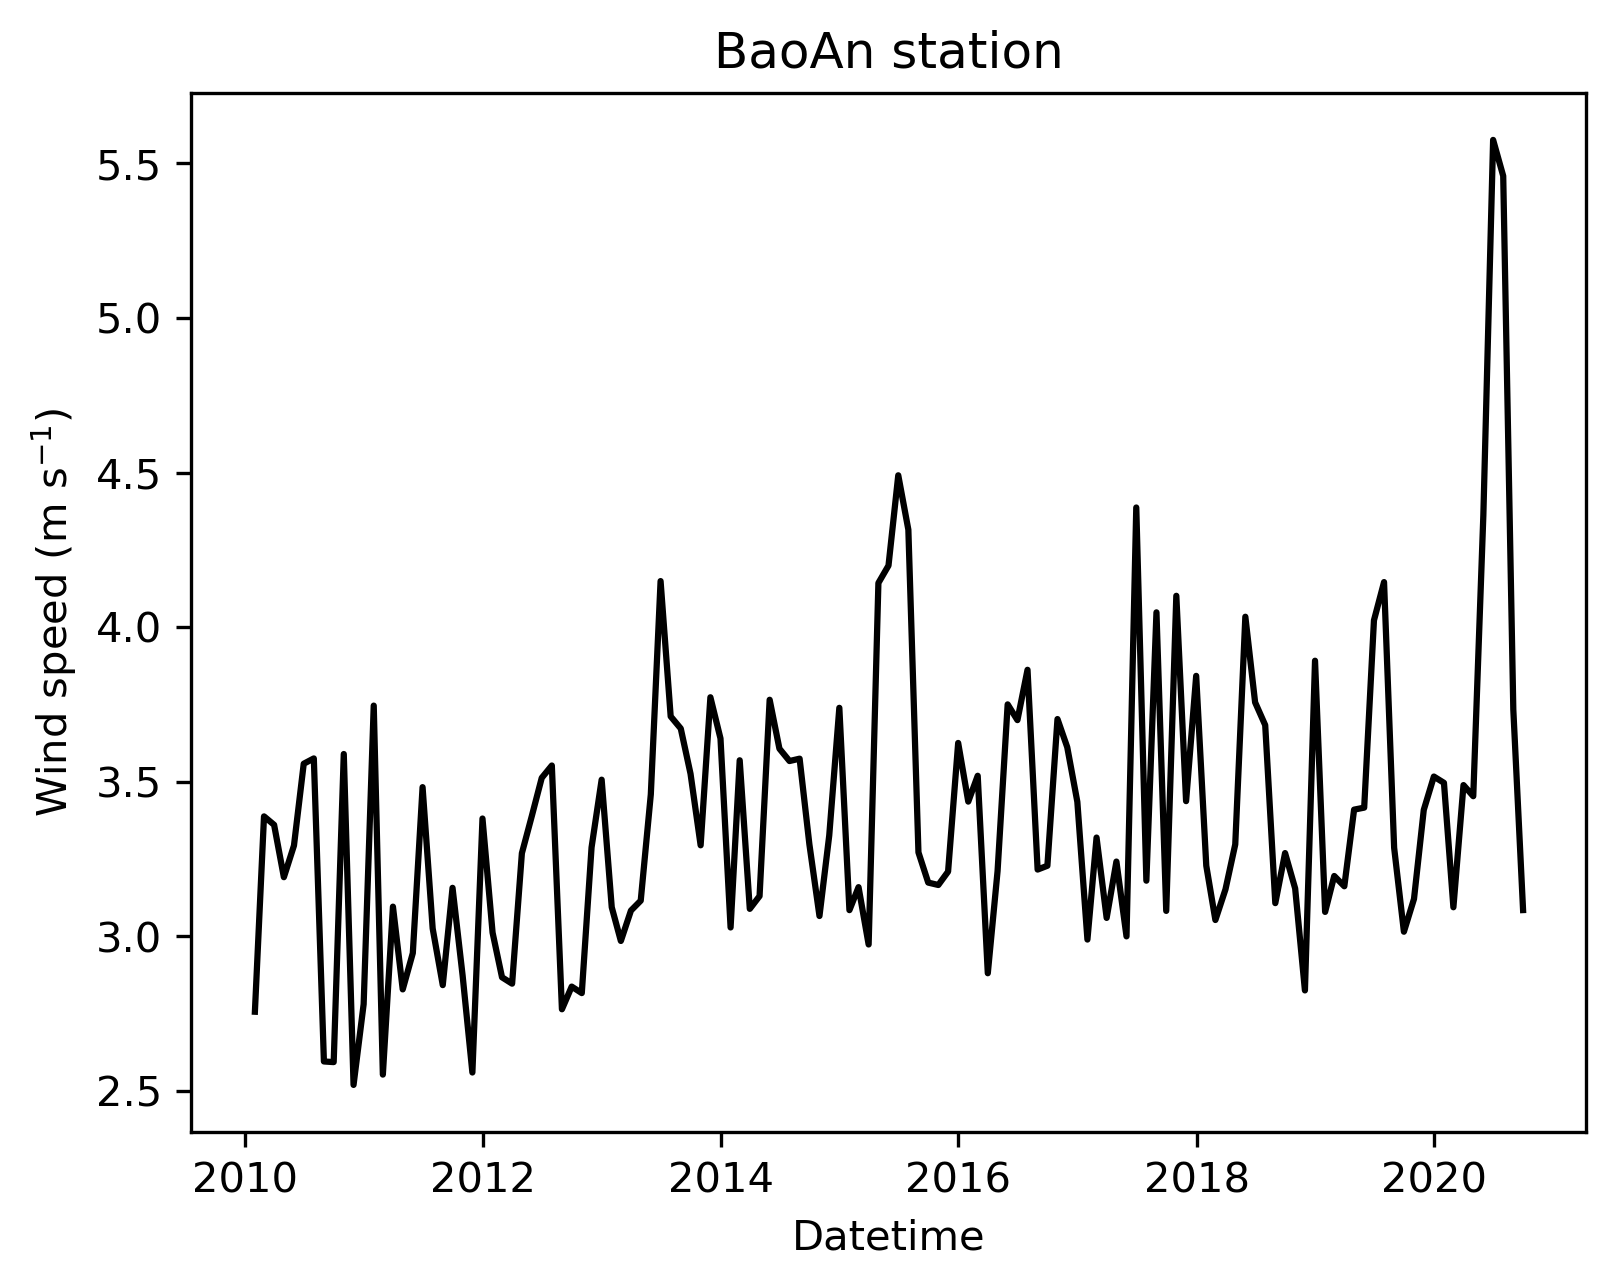

In [624]:
from io import StringIO

df = pd.read_csv("./data/2281305.csv", parse_dates=["DATE"], na_values=999).loc[:, ["STATION", "DATE", "WND"]]
wind_csv = StringIO("\n".join(df["WND"].to_list()))
df_wind = pd.read_csv(wind_csv, names=["DIRECTION", "DIRECTION QUALITY", "OBSERVATION TYPE", "SPEED", "SPEED QUALITY"], na_values=[999, 9999])
df_wind["SPEED"] /= 10
df_wind = pd.concat([df.loc[:, "DATE"], df_wind], axis=1)
qc_speed = df_wind["SPEED QUALITY"].isin([0, 1, 2, 4, 5, 6, 9])
qc_obs_type = (df_wind["OBSERVATION TYPE"]!="9")|((df_wind["OBSERVATION TYPE"]=="9")&(df_wind["SPEED"]==0))
df_wind_speed_qc = df_wind.loc[qc_obs_type&qc_speed, ["DATE", "SPEED"]]
df_wind_speed_qc.set_index("DATE", inplace=True)
# df_wind_speed_qc.resample("M").mean().plot(ylabel=r"Wind speed (m s$^{-1}$)", xlabel="Datetime", title="BaoAn station")
df_wind_speed_monthly = df_wind_speed_qc.resample("M").mean()
# df_wind_speed_monthly["SPEED_ANMO"] = np.nan
# for i in range(1, 13):
#     df_wind_speed_monthly.loc[df_wind_speed_monthly.index.month==i, "SPEED_ANMO"] = \
#         df_wind_speed_monthly.loc[df_wind_speed_monthly.index.month==i, "SPEED"] - df_wind_speed_monthly.loc[df_wind_speed_monthly.index.month==i, "SPEED"].mean()
fig = plt.figure(figsize=[6, 4.5], dpi=300)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])
ax.plot(df_wind_speed_monthly.index, df_wind_speed_monthly["SPEED"], "k-")
ax.set(xlabel="Datetime", ylabel=r"Wind speed (m s$^{-1}$)", title="BaoAn station")
fig.savefig("./images/PS2_2_figure1.jpg", bbox_inches="tight")

绘制 2010 至 2020 风速月均值如图，可以看到，相比较 2010 至 2012 年，2013 至 2020 年的平均风速有些许增加（从 3.0 增加至 3.5 m s$^{-1}$ 左右），且风速的极大值也有明显增加，尤其是在 2020 年最大月均风速达到了 5.5 m s$^{-1}$。而在 2013 到 2020 年内部则并未观察到明显的变化趋势。

## 3. Explore a data set
Browse the CASEarth, National Centers for Environmental Information (NCEI), or Advanced Global Atmospheric Gases Experiment (AGAGE) website. Search and download a data set you are interested in. You are also welcome to use data from your group in this problem set. But the data set should be in csv, XLS, or XLSX format, and have temporal information.

3.1 [5 points] Load the csv, XLS, or XLSX file, and clean possible data points with missing values or bad quality.

这里使用的数据集来源于 [Mace Head Atmospheric Research Station 的甲烷观测 Monthly Baseline 数据](https://www-air.larc.nasa.gov/missions/agage/data/)，其数据可以从 AGAGE 下载得到。考虑到网站目前仅提供 nc 格式文件，因此为了满足题目要求，这里先将目标变量时间序列转换为 csv 格式文件。其原始数据的缺失值在 nc 文件中以 NaN 格式表示，在 csv 中则以空值表示（读取后依旧为 NaN）。

In [625]:
import netCDF4 as nc
import xarray as xr

ds = xr.open_dataset("./data/agage_mhd_ch4_monthly-baseline-20250721.nc")
# ds["time"], df["mf"]
df = pd.DataFrame()
df["Time"] = ds["time"].values
df["CH4"] = ds["mf"]
df.to_csv("./data/agage_mhd_ch4_monthly.csv", index=None)
ds

<xarray.Dataset> Size: 20kB
Dimensions:           (time: 455)
Coordinates:
  * time              (time) datetime64[ns] 4kB 1987-02-01 ... 2024-12-01
Data variables:
    mf                (time) float32 2kB 1.806e+03 1.783e+03 ... 2.015e+03
    mf_repeatability  (time) float32 2kB ...
    mf_variability    (time) float32 2kB ...
    mf_count          (time) float64 4kB ...
    inlet_height      (time) float32 2kB ...
    sampling_period   (time) float64 4kB ...
    instrument_type   (time) float32 2kB ...
Attributes: (12/39)
    comment:                      Combined dataset from the following individ...
    processing_code_url:          https://github.com/AGAGE-atmosphere/agage-a...
    processing_code_version:      0.2
    data_owner_email:             s.odoherty@bristol.ac.uk
    data_owner:                   Simon O'Doherty
    station_long_name:            Mace Head, Ireland
    ...                           ...
    limit_of_detection_comment:   Data points recorded as zero mole fraction ...
    data_acknowledgements:        Please thank the listed contacts (who are n...
    data_citation_1:              (1) The DOI of this dataset
    data_citation_2:              (2) Prinn, R.G., R.F. Weiss, J. Arduini, T....
    data_citation_3:              (3) Most recent AGAGE paper publishing the ...
    baseline_flag:                git_pollution_flag

In [626]:
# 读取时间序列的表格，设置 Time 为索引，并将其解析为时间格式
df = pd.read_csv("./data/agage_mhd_ch4_monthly.csv", index_col=["Time"], parse_dates=["Time"])

3.2 [5 points] Plot the time series of a certain variable.

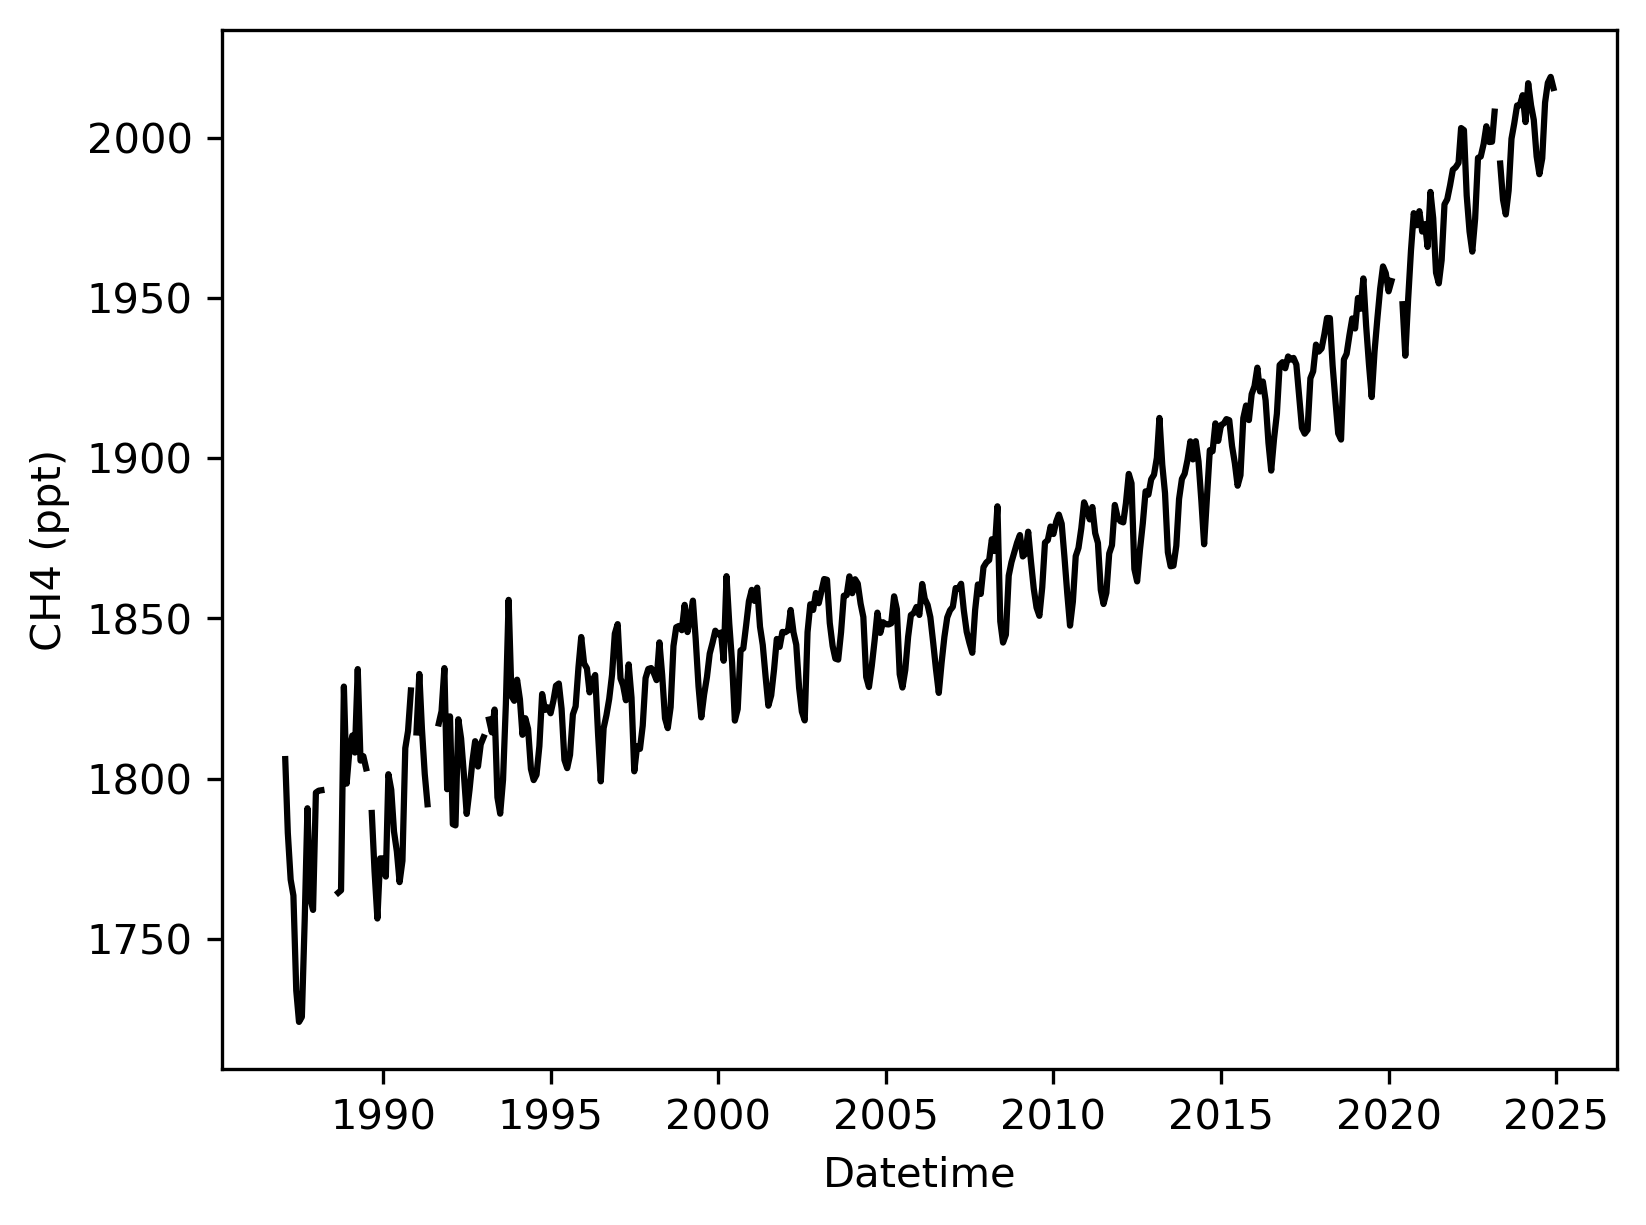

In [627]:
fig = plt.figure(figsize=[6, 4.5], dpi=300)
spec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(spec[0])
ax.plot(df.index, df["CH4"], "k-", data=df)
ax.set(ylabel="CH4 (ppt)", xlabel="Datetime")
fig.savefig("./images/PS2_3_figure1.jpg", bbox_inches="tight")

绘制了 1978 至 2025 年甲烷观测结果如图。

3.3 [5 points] Conduct at least 5 simple statistical checks with the variable, and report your findings.

这里对原始的时间序列数据进行了如下统计检查：

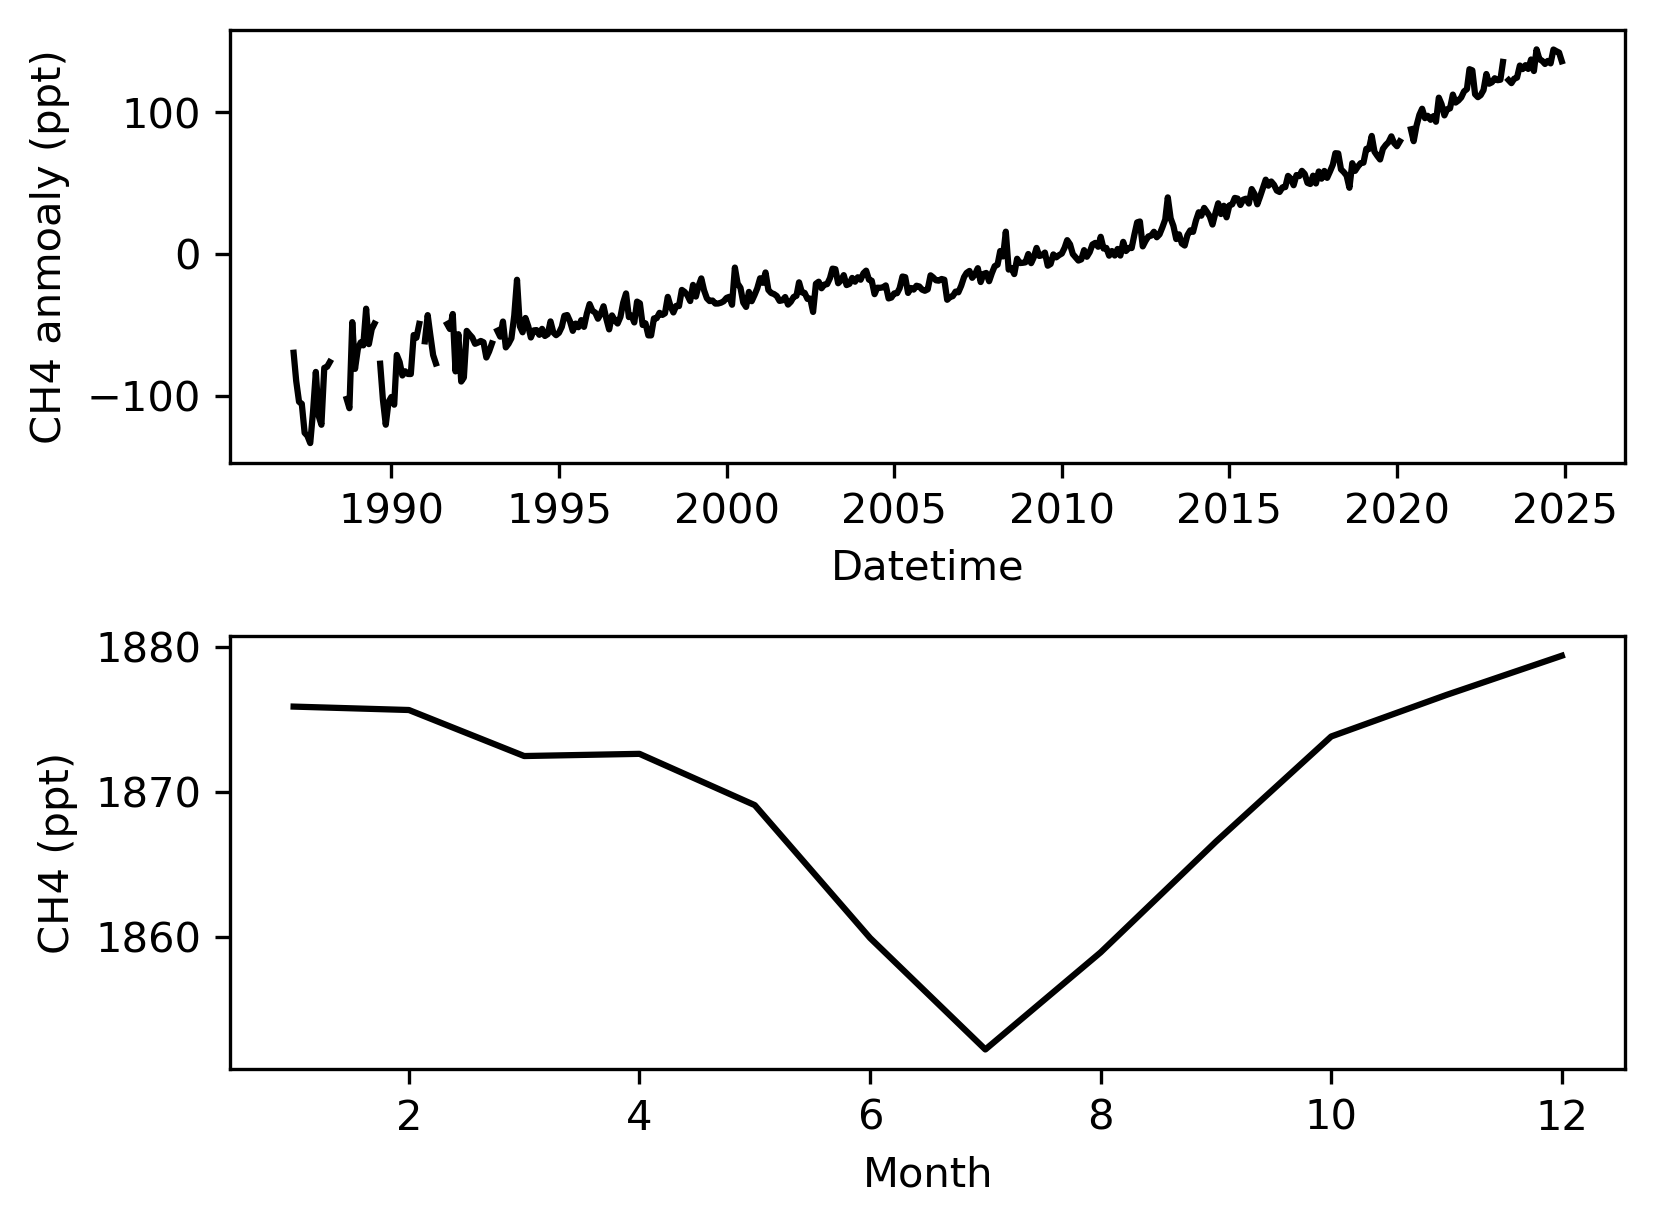

In [628]:
# 计算月份均值
df_monthly_mean = df.groupby(df.index.month).mean()
# 计算距平
df_anmo = df.copy()
df_anmo["Month"] = pd.to_datetime(df_anmo.index).month
for i in range(1, 13):
    df_anmo.loc[df_anmo["Month"]==i, "CH4"] -= df_anmo.loc[df_anmo["Month"]==i, "CH4"].mean()

fig = plt.figure(figsize=[6, 4.5], dpi=300)
spec = fig.add_gridspec(ncols=1, nrows=2, hspace=0.4)
ax = fig.add_subplot(spec[0])
ax.plot(df_anmo.index, df_anmo["CH4"], "k-")
ax.set(ylabel="CH4 anmoaly (ppt)", xlabel="Datetime")
ax = fig.add_subplot(spec[1])
ax.plot(df_monthly_mean.index, df_monthly_mean["CH4"], "k-")
ax.set(ylabel="CH4 (ppt)", xlabel="Month")
fig.savefig("./images/PS2_3_figure2.jpg", bbox_inches="tight")

In [629]:
delta_CH4_from_1987 = float(df_anmo["CH4"].max() - df_anmo["CH4"].min())
delta_CH4_season = float(df_monthly_mean["CH4"].max() - df_monthly_mean["CH4"].min())
CH4_min_month = int(df_monthly_mean.index[np.argmin(df_monthly_mean["CH4"].values)])
CH4_max_month = int(df_monthly_mean.index[np.argmax(df_monthly_mean["CH4"].values)])
delta_CH4_from_1987, delta_CH4_season, CH4_min_month, CH4_max_month

(277.80079127413137, 27.152729429429428, 7, 12)

1. 时间序列的绘图结果显示，甲烷存在明显的季节变化，为了剔除季节变化的影响，这里计算了其距平作为第一个统计量
2. 从距平我们可以获得大气甲烷浓度从 1987 年以来已经增加了 277.8 ppt，相比 1987 年增加了约 15%
3. 此外，通过对各个月份求均值可以获得甲烷的月变化曲线，可以看到每年甲烷的极差平均为 27.17 ppt
4. 另外计算了每年甲烷浓度最低的月份为 7 月，这可能和北半球夏季太阳辐射强，导致大气 ·OH 增加，更多的甲烷被氧化有关
5. 而每年甲烷浓度最高的月份为 12 月，理由同上